### Atsu Atakpa
### Natural Language Processing - Assignment 7

Cluster the reviews that you collected in homework 5, by doing the following:

    1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.

    2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact.

    3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why.

Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings. 


### Question One

In [1]:
import warnings
warnings.filterwarnings('ignore')
from __future__ import division, print_function
from nltk import word_tokenize
#from urllib.request import urlopen
from urllib2 import Request, urlopen 
from bs4 import BeautifulSoup, SoupStrainer
import nltk; print("NLTK",nltk.__version__)
import bs4; print("Beautiful Soup",bs4.__version__)
import re; print("RE",re.__version__)
import requests; print("Requests",requests.__version__)
import numpy as np ; print("Numpy: ", np.__version__)
import sys ;print("System version: ", sys.version)
from pattern.en import tag , parsetree, parse
import sklearn; print( 'sklearn ' + sklearn.__version__)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sn; print( 'seaborn ' + sn.__version__)
import matplotlib as plt; print( 'matplotlib' + plt.__version__)


NLTK 3.3
Beautiful Soup 4.6.0
RE 2.2.1
Requests 2.18.4
Numpy:  1.14.3
System version:  2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:09) [MSC v.1500 64 bit (AMD64)]
sklearn 0.19.1
seaborn 0.8.1
matplotlib2.2.2


In [2]:
#from IPython.display import HTML
#HTML('''<script>
#code_show_err=false; 
#function code_toggle_err() {
 #if (code_show_err){
 #$('div.output_stderr').hide();
 #} else {
 #$('div.output_stderr').show();
 #}
 #code_show_err = !code_show_err
#} 
#$( document ).ready(code_toggle_err);
#</script>
#To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


### Importing review URLs from csv file

In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import pprint
import re

final_df = pd.DataFrame(columns=['title','review'])
dataframe = pd.read_csv('C:/Users/atsua/OneDrive/Documents/SMU/7. Natural Language Processing/Home Work 5/Movie_review_link_new.csv',header=None)

for idx, row in dataframe.iterrows():
   url = row[0]
   response = requests.get(url)
   soup = BeautifulSoup(response.content, "html.parser")

   #print titles only
   title = soup.find("h1", class_= "header")
   #ab = print(h1.get_text())
   review = soup.find("div", class_= "text show-more__control")
   title_clean = (title.get_text().replace('Review of ',''))
   review_clean = review.get_text()
   tmp_df = pd.DataFrame({'title': [title_clean], 'review' : [review_clean]})
   final_df = final_df.append(tmp_df, ignore_index=True)

In [4]:
final_df.count()

review    106
title     106
dtype: int64

In [5]:
final_df = final_df[['title', 'review']]

In [6]:
final_df.head()

,title,review
0,The Matrix,The story of a reluctant Christ-like protagoni...
1,Avengers: Infinity War,All the reviews that say this movie has no plo...
2,Star Wars: Episode IV - A New Hope,Star Wars: Episode IV - A New Hope (1977) is a...
3,Gladiator,"Once again, Director Ridley Scott proves to be..."
4,Terminator 2: Judgment Day,A Terminator(Arnold Schwarzenegger) was sent f...


In [7]:
#final_df.to_csv('movie_reviews_dataframe.csv', encoding ='utf-8')

In [8]:
# Review of the 6th item in the our datafame
final_df.review[5]

u'Classic Action Adventure film that started Indiana Jones character and a film franchise including a TV Show series on a big screen. It is one of my personal favorite adventure movies of all time. It was my second movie that I have saw and It will be always the best one in the series no order. Easily one of the best movies till this date I always enjoy this movie. Best Indiana Jones and Steven Spielberg film ever.Raiders has more energy than three action films. And that is what makes it the classic that it is.Raiders is such a great film, containing some great action scenes (the Truck scene) and creating Indiana Jones, which is the best adventure hero ever made, partly I think due to Harrison Ford (I don\'t think these movies would have been as good with Tom Selleck). Raiders of the Lost Ark (1981) also won 4 Academy Awards including for Best Art Direction-Set Decoration,Best Sound,Best Film Editing and Best Effects, Visual Effects.The Effects were awesome and amazing in this film, th

In [9]:
from normalization import normalize_corpus
from utils import build_feature_matrix

# normalize corpus
norm_movie_synopses = normalize_corpus(final_df.review,
                                       lemmatize=True,
                                       only_text_chars=True)

# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))
# view number of features
print (feature_matrix.shape)    

(106, 37)


  #### The shape of our feature matrix is 106 movie reviews and 37 features each

In [10]:
# get feature names
feature_names = vectorizer.get_feature_names()
# print sample features
print (feature_names[:41])  

[u'action', u'actor', u'best', u'character', u'could', u'end', u'even', u'film', u'first', u'give', u'good', u'great', u'know', u'like', u'look', u'love', u'many', u'movie', u'much', u'people', u'plot', u'really', u'scene', u'show', u'still', u'story', u'take', u'thing', u'think', u'time', u'want', u'watch', u'way', u'well', u'work', u'would', u'year']


##### These 37 features are TF-IDF based features for unigram and bigrams. Each feature occurs in at least 25% to a maximum of 85% of documents.

### K-Means Clustering (K=5)

In [11]:
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

num_clusters = 5    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
final_df['Cluster'] = clusters

In [12]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

[(0, 21), (1, 30), (2, 19), (3, 19), (4, 17)]


In [13]:
def get_cluster_data(clustering_obj, final_df, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = final_df[final_df['Cluster'] == cluster_num]['title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details

In [14]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('Movies in this cluster:')
        print (', '.join(cluster_details['movies']))
        print ('='*40)

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': final_df['Cluster'].values.tolist(),
                                       'title': final_df['title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

In [16]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 final_df=final_df,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=10)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: [u'film', u'would', u'movie', u'know', u'even', u'way', u'take', u'time', u'character', u'like']
Movies in this cluster:
The Matrix, Batman Begins, Ran, Bahubali: The Beginning, Bahubali: The Beginning, The General, The General, The General, Sanjuro, Haider, Haider, Haider, Fraud Business, Guardians of the Galaxy, Logan, Kill Bill: Vol. 1, Akira, Akira, Elite Squad, Mission: Impossible - Fallout, Deadpool
Cluster 1 details:
--------------------
Key features: [u'movie', u'watch', u'good', u'story', u'like', u'time', u'character', u'could', u'much', u'give']
Movies in this cluster:
Avengers: Infinity War, Terminator 2: Judgment Day, User Reviews, Star Wars: Episode VI - Return of the Jedi, Bahubali: The Beginning, Bahubali: The Beginning, Bahubali: The Beginning, Sanjuro, Haider, Haider, Haider, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Guardians of the Galaxy, Kill

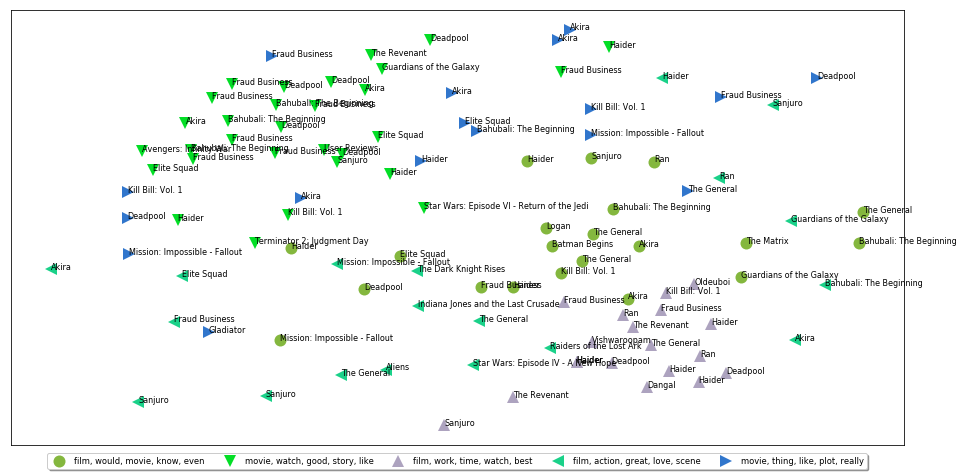

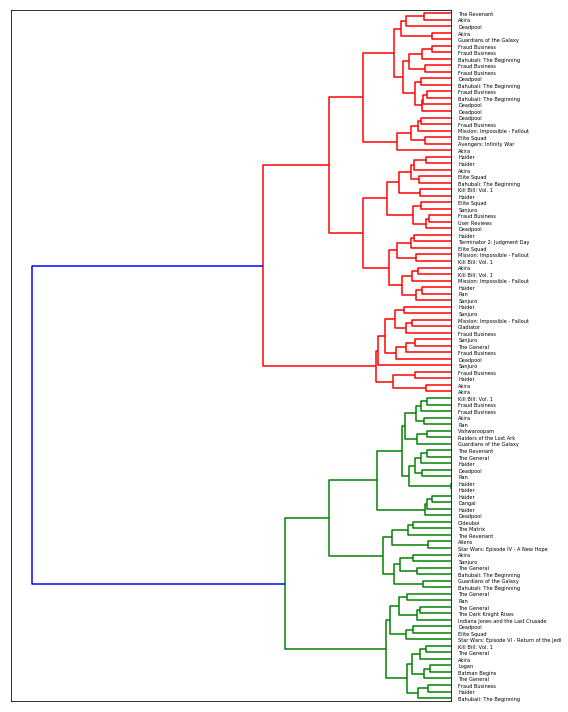

In [17]:
#print_cluster_data(cluster_data) 
import warnings
warnings.filterwarnings('ignore')

plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=final_df,
              plot_size=(16,8)) 





from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix
    
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=final_df,
                           figure_size=(8,10))

### K-Means Clustering (K = 2)

In [18]:
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=2):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

num_clusters = 2    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
final_df['Cluster'] = clusters

### Scree plot to select the appropriate k-value

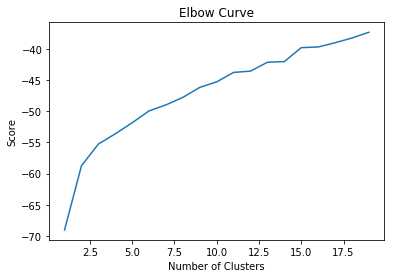

In [19]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(feature_matrix).score(feature_matrix) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [20]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

[(0, 59), (1, 47)]


In [21]:
def get_cluster_data(clustering_obj, final_df, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = final_df[final_df['Cluster'] == cluster_num]['title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details

In [22]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('Movies in this cluster:')
        print (', '.join(cluster_details['movies']))
        print ('='*40)

In [23]:
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': final_df['Cluster'].values.tolist(),
                                       'title': final_df['title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

In [24]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 final_df=final_df,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=10)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: [u'movie', u'like', u'good', u'time', u'watch', u'story', u'character', u'even', u'plot', u'could']
Movies in this cluster:
Avengers: Infinity War, Gladiator, Terminator 2: Judgment Day, User Reviews, Star Wars: Episode VI - Return of the Jedi, Ran, Bahubali: The Beginning, Bahubali: The Beginning, Bahubali: The Beginning, Bahubali: The Beginning, Sanjuro, Sanjuro, Sanjuro, Haider, Haider, Haider, Haider, Haider, Haider, Haider, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Fraud Business, Guardians of the Galaxy, Kill Bill: Vol. 1, Kill Bill: Vol. 1, Kill Bill: Vol. 1, Akira, Akira, Akira, Akira, Akira, Akira, Akira, Elite Squad, Elite Squad, Elite Squad, Elite Squad, Elite Squad, Mission: Impossible - Fallout, Mission: Impossible - Fallout, Mission: Impossible - Fallout, Mission: Impossible - Fallout, Deadpool, Deadpool, Deadpool, Dea

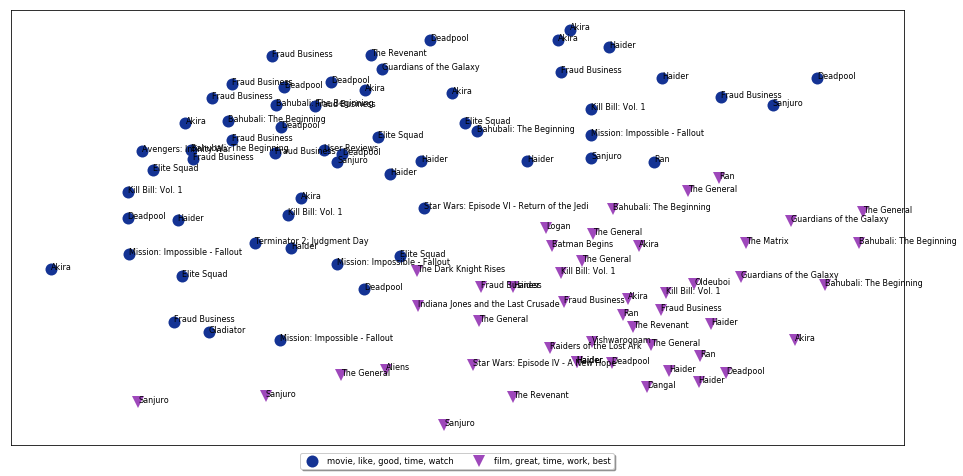

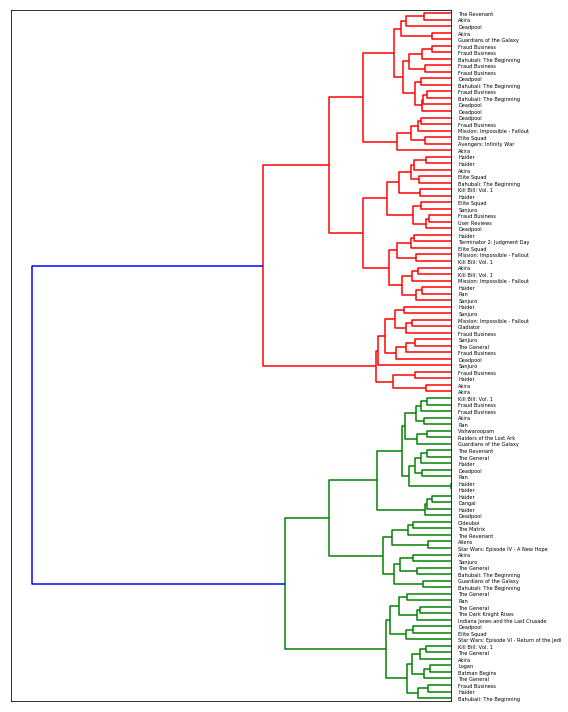

In [25]:
#print_cluster_data(cluster_data) 
import warnings
warnings.filterwarnings('ignore')

plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=final_df,
              plot_size=(16,8)) 





from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix
    
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=final_df,
                           figure_size=(8,10))

#### Question 2

The K means algorithm is attempting to group each review in it's respective cluster. Semantically this is not an easy task to accomplish. When we set the k value to 2, the reviews are very well segmented with evidence being in the visuals above. However, the visuals also suggest that there are more than two clusters. The scree plot above was also generated from the data and suggest that we attempt kmeans with the value of 2. But to find the best centers and groupings, we must explore different values of k and setting k to 5 suggest that we do have more than two clusters. Semantically, it's not easy to find the meaning in each review that's why when the k value is 5, it has multiple words repeated in each cluster.

#### Question 3

The preferable size for the cluster is 5. The result from cluster 2 is better structured than that of cluster 5 however, both results suggest that we have more than 2 or even 5 clusters. Different values of K has to be tested to find the most optimal centers for the reviews.